In [1]:
import pandas as pd

df = pd.read_csv('genomic_species.csv')
df.head(1)

,Unnamed: 0,sequence,description,start_pos,end_pos,fasta_url,original_url,group,genus,species_epithet,set
0,0,CAGCGGCGTCCCCACGCTACTGATGGCACGCACAGACGCACAGGCG...,NZ_AYSW01000002.1 Robbsia andropogonis Ba3549 ...,0,6200,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...,https://ftp.ncbi.nlm.nih.gov/genomes/refseq/ba...,bacteria,Robbsia,andropogonis,train


In [ ]:
import haiku as hk
import jax
import jax.numpy as jnp
from nucleotide_transformer.pretrained import get_pretrained_model
from tqdm import tqdm

# Get pretrained model
parameters, forward_fn, tokenizer, config = get_pretrained_model(
    model_name="500M_multi_species_v2",
    embeddings_layers_to_save=(20,),
    max_positions=5012,
)
forward_fn = hk.transform(forward_fn)


def get_embedding(sequences):
    tokens_ids = [b[1] for b in tqdm(tokenizer.batch_tokenize(sequences))]
    tokens = jnp.asarray(tokens_ids, dtype=jnp.int32)

    random_key = jax.random.PRNGKey(0)

    # Infer
    outs = forward_fn.apply(parameters, random_key, tokens)

    print(outs["embeddings_20"].shape)
    return outs["embeddings_20"]

Downloaded model's hyperparameters.
Downloaded model's weights...


In [19]:
get_embedding(list(df['sequence'])[:2])

100%|██████████| 2/2 [00:00<00:00, 36954.22it/s]


(2, 5012, 1024)


Array([[[-2.191554  ,  1.4415268 ,  2.1551042 , ...,  4.8995013 ,
         -0.32978684, -0.0639534 ],
        [-0.166973  , -0.5188094 , -1.1043674 , ...,  6.202292  ,
         -0.08486992,  1.9263216 ],
        [-0.21487129,  0.5069895 , -1.2656559 , ...,  7.7112293 ,
         -0.86633456,  3.1677861 ],
        ...,
        [-0.86685055,  3.470413  ,  5.0875573 , ..., -4.2454243 ,
          0.8142672 ,  5.4392943 ],
        [-0.86685055,  3.470413  ,  5.0875573 , ..., -4.2454243 ,
          0.8142672 ,  5.4392943 ],
        [-0.86685055,  3.470413  ,  5.0875573 , ..., -4.2454243 ,
          0.8142672 ,  5.4392943 ]],

       [[-2.2090287 ,  1.1340915 , -0.16971505, ...,  2.9246316 ,
          0.93279195, -2.5067496 ],
        [-0.47675288,  1.2189764 ,  1.8123672 , ...,  0.26726687,
          2.2782972 , -0.9404712 ],
        [ 1.1792512 ,  1.4786634 ,  1.6423494 , ..., -0.79807603,
          4.1725016 ,  0.14908274],
        ...,
        [-0.6720576 ,  3.3047614 ,  5.2680807 , ..., -

In [2]:
import haiku as hk
import jax
import jax.numpy as jnp
from nucleotide_transformer.pretrained import get_pretrained_model

/Users/zongxiali/anaconda3/envs/genomics_transformers/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
model_name = '50M_multi_species_v2'

In [ ]:
parameters, forward_fn, tokenizer, config = get_pretrained_model(
    model_name=model_name,
    embeddings_layers_to_save=(12,),
    attention_maps_to_save=((1, 4), (7, 16)),
    max_positions=2048,
)
forward_fn = hk.transform(forward_fn)

Downloaded model's hyperparameters.
Downloaded model's weights...


In [5]:
# Get data and tokenize it
# sequences = [
#     "ATTCCGAAATCGCTGACCGATCGTACGAAA",
#     "ATTTCTCTCTCTCTCTGAGATCGATCGATCGATATCTCTCGAGCTAGC",
# ]

sequences = list(df['sequence'])[:2]
tokens_ids = [b[1] for b in tokenizer.batch_tokenize(sequences)]
tokens_str = [b[0] for b in tokenizer.batch_tokenize(sequences)]
tokens = jnp.asarray(tokens_ids, dtype=jnp.int32)

In [ ]:
%%time
random_key = jax.random.PRNGKey(0)

# Infer
outs = forward_fn.apply(parameters, random_key, tokens)

CPU times: user 15.3 s, sys: 4.28 s, total: 19.6 s
Wall time: 4.68 s


In [7]:
print(outs["embeddings_12"].shape)

(2, 2048, 512)


In [ ]:
embeddings = outs["embeddings_12"][:, 1:, :]  
padding_mask = jnp.expand_dims(tokens[:, 1:] != tokenizer.pad_token_id, axis=-1)
masked_embeddings = embeddings * padding_mask  
sequences_lengths = jnp.sum(padding_mask, axis=1)
mean_embeddings = jnp.sum(masked_embeddings, axis=1) / sequences_lengths

In [9]:
print(mean_embeddings.shape)

(2, 512)


In [10]:
print(outs["attention_map_layer_1_number_4"].shape)

(2, 2048, 2048)


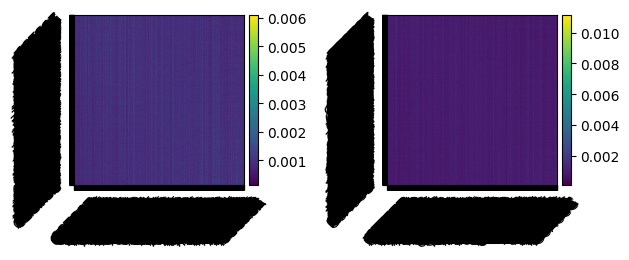

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# plot attention maps
fig, axes = plt.subplots(nrows=1, ncols=2)

seq_length0, seq_length1 = int(sequences_lengths[0][0]), int(sequences_lengths[1][0])

# plot for first seq in the batch
im0 = axes[0].imshow(
    outs["attention_map_layer_1_number_4"][
        0, 1 : (seq_length0 + 1), 1 : (seq_length0 + 1)
    ]
)
divider0 = make_axes_locatable(axes[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
tokens0 = tokens_str[0][1 : (seq_length0 + 1)]
axes[0].set_xticks(list(range(seq_length0)), tokens0, rotation=45)
axes[0].set_yticks(list(range(seq_length0)), tokens0, rotation=45)
fig.colorbar(im0, cax=cax0, orientation="vertical")

# plot for second seq in the batch
im1 = axes[1].imshow(
    outs["attention_map_layer_1_number_4"][
        1, 1 : (seq_length1 + 1), 1 : (seq_length1 + 1)
    ]
)
divider1 = make_axes_locatable(axes[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
tokens1 = tokens_str[1][1 : (seq_length1 + 1)]
axes[1].set_xticks(list(range(seq_length1)), tokens1, rotation=45)
axes[1].set_yticks(list(range(seq_length1)), tokens1, rotation=45)
fig.colorbar(im1, cax=cax1, orientation="vertical")

fig.tight_layout()

In [ ]:
logits = outs["logits"]
probabilities = []


for seq_id in range(logits.shape[0]):

    logits_seq = logits[seq_id]
    seq_length = int(sequences_lengths[seq_id][0])
    logits_seq = logits_seq[1 : (seq_length + 1)]  
    probas = jax.nn.softmax(
        logits_seq, axis=-1
    )  

    print(probas.shape)
    probabilities.append(probas)

(1035, 4107)
(1035, 4107)


In [13]:
sequence_id = 0
position_id = 1

probs = probabilities[sequence_id][position_id]
sorted_positions = jnp.argsort(-probs)
sorted_probs = probs[sorted_positions]

top_k = 5
for k in range(top_k):
    predicted_token = tokenizer.id_to_token(int(sorted_positions[k]))
    prob = sorted_probs[k]
    print(f"token: {predicted_token}, probability: {prob * 100:.2f}%")

token: CGTCCC, probability: 71.28%
token: CGCGGC, probability: 0.26%
token: CATCGG, probability: 0.23%
token: CTTCGC, probability: 0.17%
token: CATCCC, probability: 0.16%


In [4]:
import pandas as pd

df = pd.read_csv('./genomic_species.csv')
df.head(1)

,rowID,sequence,description,start_pos,end_pos,fasta_url,original_url,group,genus,species_epithet,set
0,0,CAGCGGCGTCCCCACGCTACTGATGGCACGCACAGACGCACAGGCG...,NZ_AYSW01000002.1 Robbsia andropogonis Ba3549 ...,0,6200,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...,https://ftp.ncbi.nlm.nih.gov/genomes/refseq/ba...,bacteria,Robbsia,andropogonis,train


In [2]:
set(list(df['group']))

{'bacteria',
 'fungi',
 'invertebrate',
 'protozoa',
 'vertebrate_mammalian',
 'vertebrate_other'}

In [3]:
len(list(df['sequence'])[0])

6200